<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Spring2025/blob/main/Module_5/26_PYMC_BayesianEZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The notebook for the University of Tennessee, Knoxville, Department of Materials Science and Engineering Spring 2024 course, MSE510.
- Instructor Sergei V. Kalinin

- These examples are based on the book "Bayesian Analysis with Python" by Oswaldo Martin, https://subscription.packtpub.com/book/data/9781805127161/pref

The convenient library for the visualization of the Markov Chain Monte Carlo (MCMC) results is Arviz, https://python.arviz.org/en/stable/


In [1]:
!pip install arviz

import arviz as az
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import norm, binom, beta, bernoulli, t, multivariate_normal, poisson, randint, entropy, laplace, logistic

## Visualizing distributions

[0.50942556 0.32436882 0.53274711 0.62052941 0.50355083 0.34842313
 0.15231727 0.44541788 0.24759739 0.29063561]


<Axes: title={'center': 'x'}>

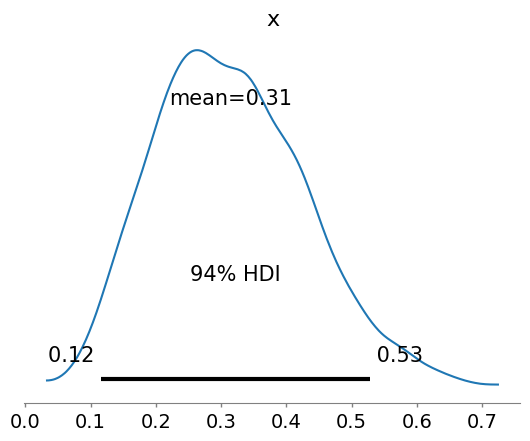

In [3]:
np.random.seed(1)
print(beta.rvs(5, 11, size=10))

az.plot_posterior(beta.rvs(5, 11, size=3000))

## First Bayesian model

There are multiple packages for Bayesian analysis. The relatively simple one is PYMC.

In [4]:
import pymc as pm

Let's first simply fit a data to a model - meaning determine the parameters of the distribution from which the data has been drawn. However, note that it doesn't have to be the same distribution - this is a **hypothesis** we are making!

In [5]:
np.random.seed(123)
trials = 30
theta_real = 0.35 # unknown value in a real experiment
data = bernoulli.rvs(p=theta_real, size=trials)
print(data)

[1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0]


Output()

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>]],
      dtype=object)

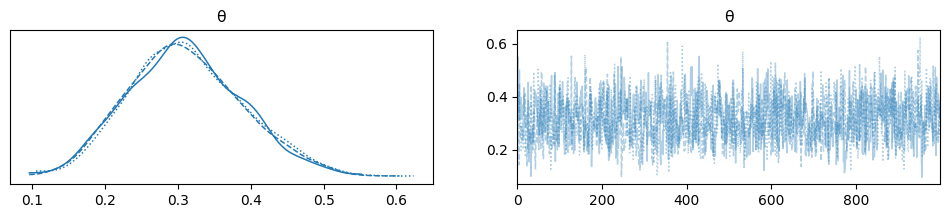

In [6]:
with pm.Model() as our_first_model:
    θ = pm.Beta('θ', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=θ, observed=data)
    trace = pm.sample(1000, random_seed=123, chains = 3)

az.plot_trace(trace)

Let's look at diagnostics:

In [7]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.311,0.079,0.172,0.464,0.002,0.001,1212.0,1788.0,1.01


<Axes: title={'center': 'θ'}>

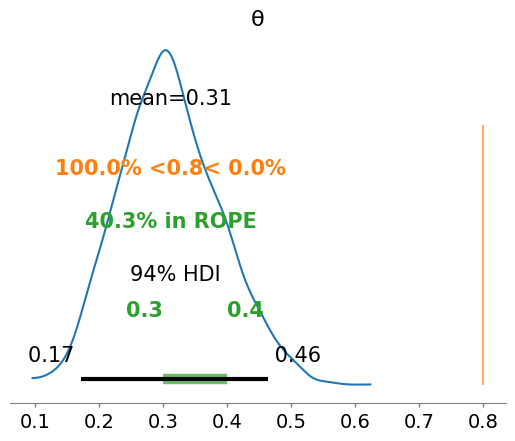

In [8]:
az.plot_posterior(trace, rope = [0.3, 0.4], ref_val = 0.8)

We can also use our posteriors to predict some more complex loss functions. For example, it can be cost and time for experiment, etc.

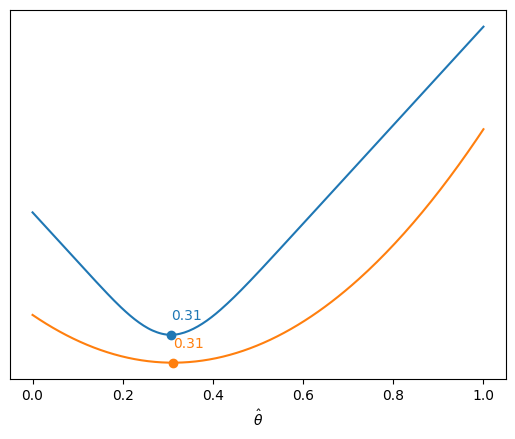

In [9]:
grid = np.linspace(0, 1, 200)
θ_pos = trace.posterior['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')
plt.savefig('B11197_02_05.png')

This fucntion can be very complicated.

Text(0.5, 0, '$\\hat \\theta$')

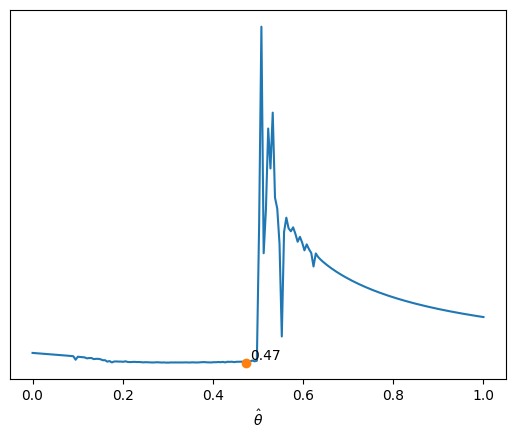

In [10]:
lossf = []
for i in grid:
    if i < 0.5:
        f = 1/np.mean(np.pi * θ_pos / np.abs(i - θ_pos))
    else:
        f = np.mean(1 / (i - θ_pos))
    lossf.append(f)

mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
             (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')

## Fitting data to distribution

Now, let's do it one more time for a Gaussian model. Here, we have several parameters (mead and dispersion).

<Axes: title={'center': 'x'}>

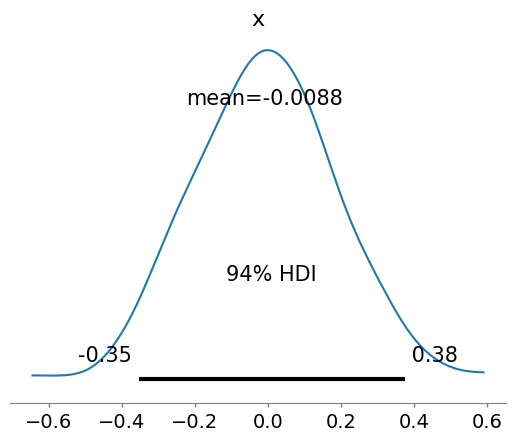

In [11]:
# arr = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.8, 0.16, 0.32, 0.50, 0.150])

μ, σ = 0., 0.2
X = norm(μ, σ)
arr = X.rvs(300)

az.plot_posterior(arr)

In [12]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=-1, upper=2)
    σ = pm.HalfNormal('σ', sigma=1)
    y = pm.Normal('y', mu=μ, sigma=σ, observed=arr)
    idata_g = pm.sample(1000)

Output()

array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

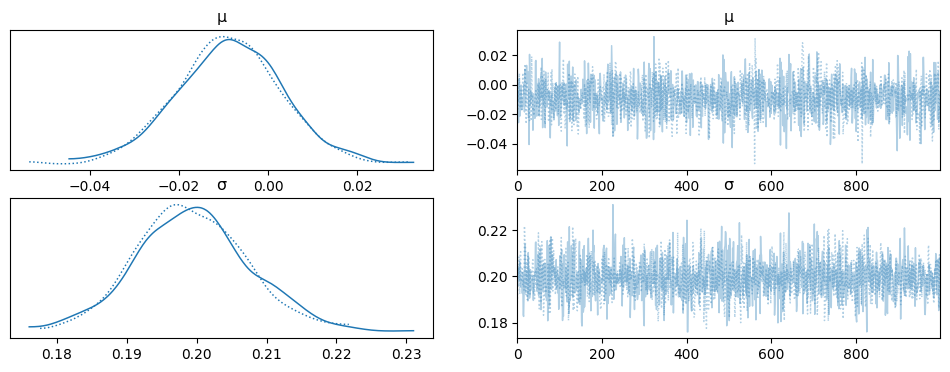

In [13]:
az.plot_trace(idata_g)

<Axes: xlabel='μ', ylabel='σ'>

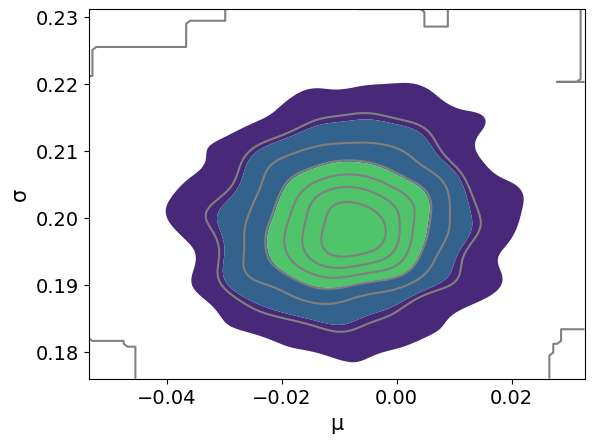

In [14]:
az.plot_pair(idata_g, kind='kde')

In [15]:
az.summary(idata_g)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,-0.009,0.012,-0.033,0.013,0.0,0.0,1962.0,1447.0,1.0
σ,0.199,0.008,0.185,0.215,0.0,0.0,1973.0,1460.0,1.0


In [16]:
pm.sample_posterior_predictive(idata_g, model=model_g, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(array([ 1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  2.,  1.,  3.,  3.,  3.,
         4.,  7., 11.,  5., 10.,  6., 14., 13., 11.,  7., 19., 17., 13.,
        14., 16., 18., 13., 10., 15., 12.,  5.,  8.,  5.,  6.,  7.,  4.,
         3.,  3.,  3.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.]),
 array([-0.646211  , -0.62145228, -0.59669356, -0.57193484, -0.54717611,
        -0.52241739, -0.49765867, -0.47289995, -0.44814123, -0.42338251,
        -0.39862378, -0.37386506, -0.34910634, -0.32434762, -0.2995889 ,
        -0.27483017, -0.25007145, -0.22531273, -0.20055401, -0.17579529,
        -0.15103657, -0.12627784, -0.10151912, -0.0767604 , -0.05200168,
        -0.02724296, -0.00248423,  0.02227449,  0.04703321,  0.07179193,
         0.09655065,  0.12130937,  0.1460681 ,  0.17082682,  0.19558554,
         0.22034426,  0.24510298,  0.26986171,  0.29462043,  0.31937915,
         0.34413787,  0.36889659,  0.39365531,  0.41841404,  0.44317276,
         0.46793148,  0.4926902 ,  0.51744892,  0.54220765,

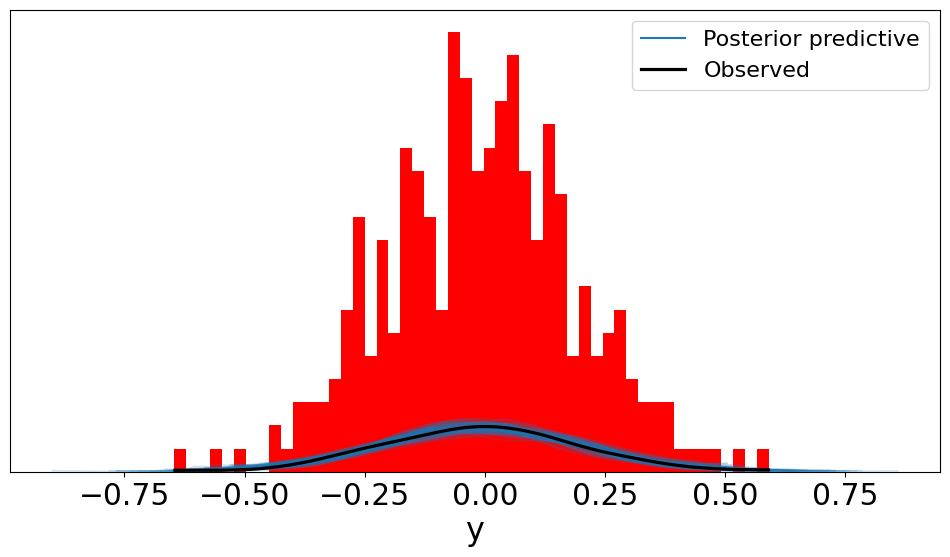

In [17]:
ax = az.plot_ppc(idata_g, num_pp_samples=100, figsize=(12, 6), mean=False)
plt.hist(arr, bins = 50, color = 'r')

## Linear regression

Now, let's explore how we can use Bayesian methods to fit data with the linear function. First, we make and plot some data.

In [18]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

Text(0.5, 0, 'y')

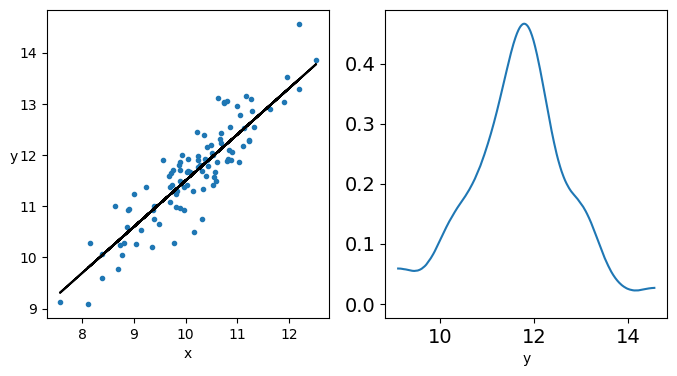

In [19]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')

Next, we define the probabilistic model.

In [20]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=y)

    idata_g = pm.sample(2000, tune=2000)

Output()

And voila! Note that in the code below we **draw** pairs of parameters alpha and beta (i.e. offset and slope) and plot the lines corresponding to each pair.

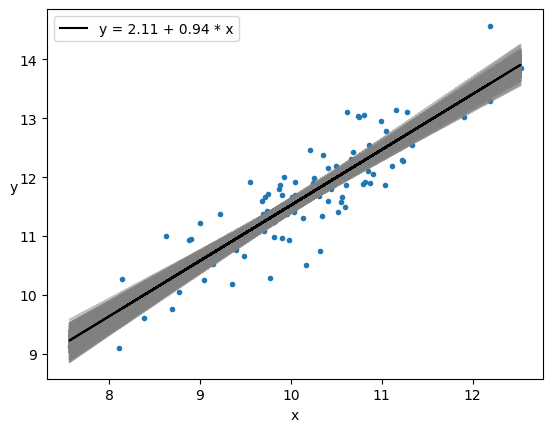

In [21]:
plt.plot(x, y, 'C0.')

posterior_g = az.extract(idata_g)
alpha_m = posterior_g['α'].mean().item()
beta_m = posterior_g['β'].mean().item()

draws = range(0, posterior_g.sample.size, 10)
plt.plot(x, posterior_g['α'][draws].values + posterior_g['β'][draws].values * x[:,None], c='gray', alpha=0.5)

plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

We can look at the same summary. Note that now our model calculated the distirbution fo each point in the parameter space (if you were wondering where the high dimensional parameter spaces are coming from).

In [22]:
az.summary(idata_g)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2.107,0.486,1.134,2.973,0.013,0.009,1378.0,1566.0,1.0
β,0.942,0.048,0.853,1.032,0.001,0.001,1388.0,1540.0,1.0
μ[0],11.103,0.054,11.003,11.206,0.001,0.001,2282.0,2833.0,1.0
μ[1],12.677,0.069,12.552,12.813,0.001,0.001,2137.0,2534.0,1.0
μ[2],11.904,0.048,11.813,11.991,0.001,0.001,3842.0,2582.0,1.0
...,...,...,...,...,...,...,...,...,...
μ[96],12.091,0.051,11.996,12.188,0.001,0.001,3314.0,2722.0,1.0
μ[97],11.920,0.048,11.828,12.006,0.001,0.001,3817.0,2673.0,1.0
μ[98],12.288,0.056,12.179,12.392,0.001,0.001,2752.0,2820.0,1.0
μ[99],12.508,0.063,12.394,12.631,0.001,0.001,2349.0,2454.0,1.0


Let's look at joint distribution. To make things easy, we just pull the pairs of (slope, offset) as individual traces, and analyze them via Seaborn.

In [23]:
import seaborn as sns

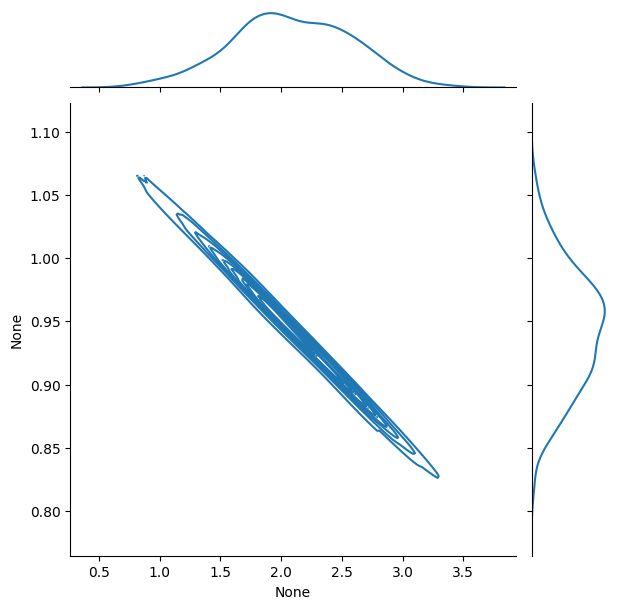

In [24]:
sns.jointplot(x = posterior_g['α'][draws].values, y = posterior_g['β'][draws].values,kind='kde')

Now, we can calculate the highest density interval (HDI) for the predicted behaviors.

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


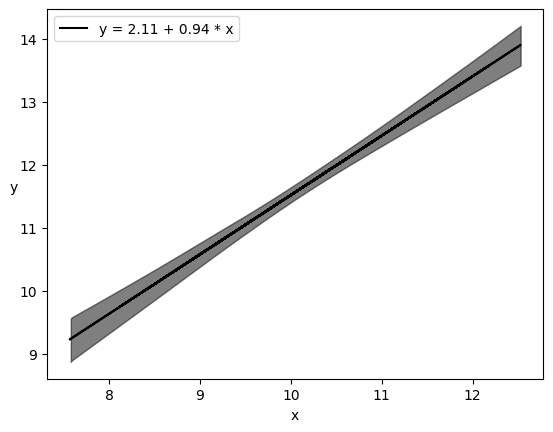

In [25]:
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

sig = az.plot_hdi(x, posterior_g['μ'].T, hdi_prob=0.99, color='k')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

We can also run the posterior predictive check to see whether the data is consistent with the model.

In [26]:
ppc = pm.sample_posterior_predictive(idata_g, model=model_g)

Output()

Text(0, 0.5, 'y')

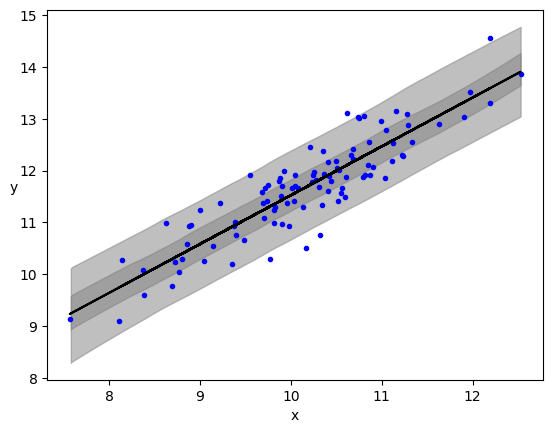

In [27]:
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

az.plot_hdi(x, ppc.posterior_predictive['y_pred'], hdi_prob=0.5, color='gray')
az.plot_hdi(x, ppc.posterior_predictive['y_pred'], color='gray')

plt.xlabel('x')
plt.ylabel('y', rotation=0)

## Robust regression

Here, we are going to explore Bayesian linear fit of the data set with the strong outlier. Previously, we have used the RANSAC method for it. Now, let's see what Bayesian linear fit can do!

In [28]:
import seaborn as sns
import scipy.stats as stats

In [29]:
ans = sns.load_dataset('anscombe')
print(ans)

   dataset     x      y
0        I  10.0   8.04
1        I   8.0   6.95
2        I  13.0   7.58
3        I   9.0   8.81
4        I  11.0   8.33
5        I  14.0   9.96
6        I   6.0   7.24
7        I   4.0   4.26
8        I  12.0  10.84
9        I   7.0   4.82
10       I   5.0   5.68
11      II  10.0   9.14
12      II   8.0   8.14
13      II  13.0   8.74
14      II   9.0   8.77
15      II  11.0   9.26
16      II  14.0   8.10
17      II   6.0   6.13
18      II   4.0   3.10
19      II  12.0   9.13
20      II   7.0   7.26
21      II   5.0   4.74
22     III  10.0   7.46
23     III   8.0   6.77
24     III  13.0  12.74
25     III   9.0   7.11
26     III  11.0   7.81
27     III  14.0   8.84
28     III   6.0   6.08
29     III   4.0   5.39
30     III  12.0   8.15
31     III   7.0   6.42
32     III   5.0   5.73
33      IV   8.0   6.58
34      IV   8.0   5.76
35      IV   8.0   7.71
36      IV   8.0   8.84
37      IV   8.0   8.47
38      IV   8.0   7.04
39      IV   8.0   5.25
40      IV  19.0

In [30]:
x_3 = ans[ans.dataset == 'III']['x'].values
y_3 = ans[ans.dataset == 'III']['y'].values
x_3 = x_3 - x_3.mean()

[]

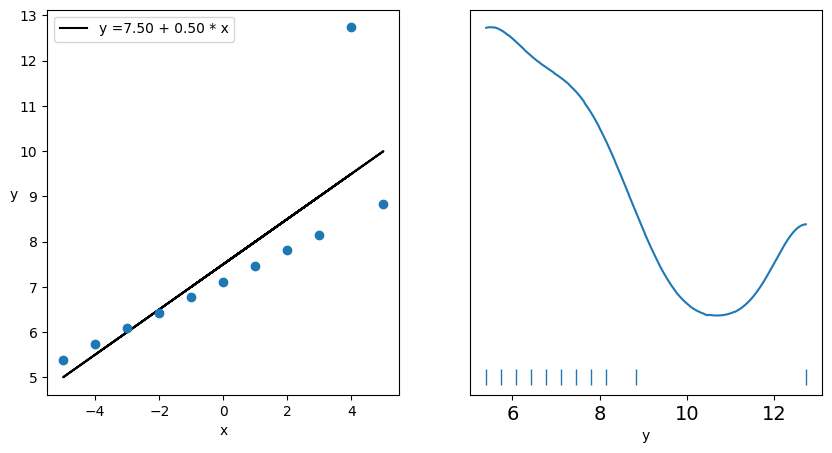

In [31]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
ax[0].plot(x_3, (alpha_c + beta_c * x_3), 'k',
           label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x')
ax[0].plot(x_3, y_3, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].legend(loc=0)
az.plot_kde(y_3, ax=ax[1], rug=True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])

We can introduce distributions that account for outliers - e.g. Student distribution

(-5.0, 5.0)

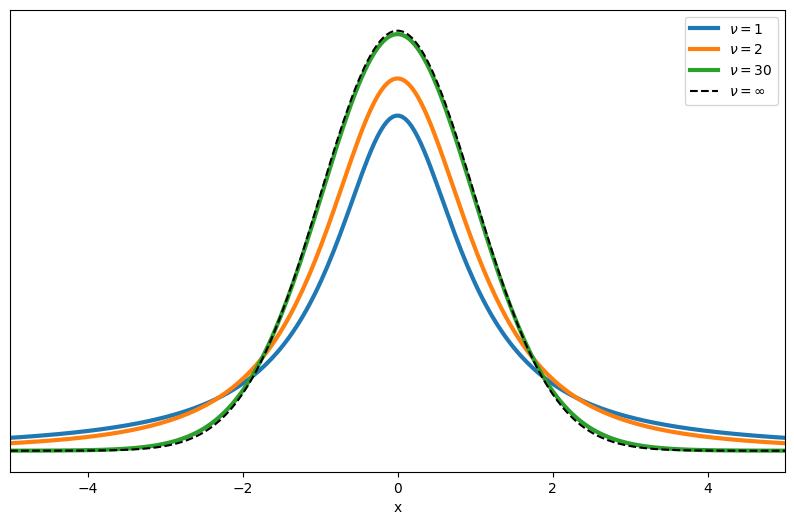

In [32]:
plt.figure(figsize=(10, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)

Let's define the model. Note that we have (going from bottom up):
- defined our process as Student distribution where mean is the linear function of parameters alpha and beta and there is noise epsilon
- the parameter v of student's distribution is given by exponential distribution
- noise epsilon has half-Normal distribution
- parameters alpha and beta have normal distributions estimated from observed data

In [33]:
with pm.Model() as model_t:
    α = pm.Normal('α', mu=y_3.mean(), sigma=1)
    β = pm.Normal('β', mu=0, sigma=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 10)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_3,
                         sigma=ϵ, nu=ν, observed=y_3)

    idata_t = pm.sample(2000)

Output()

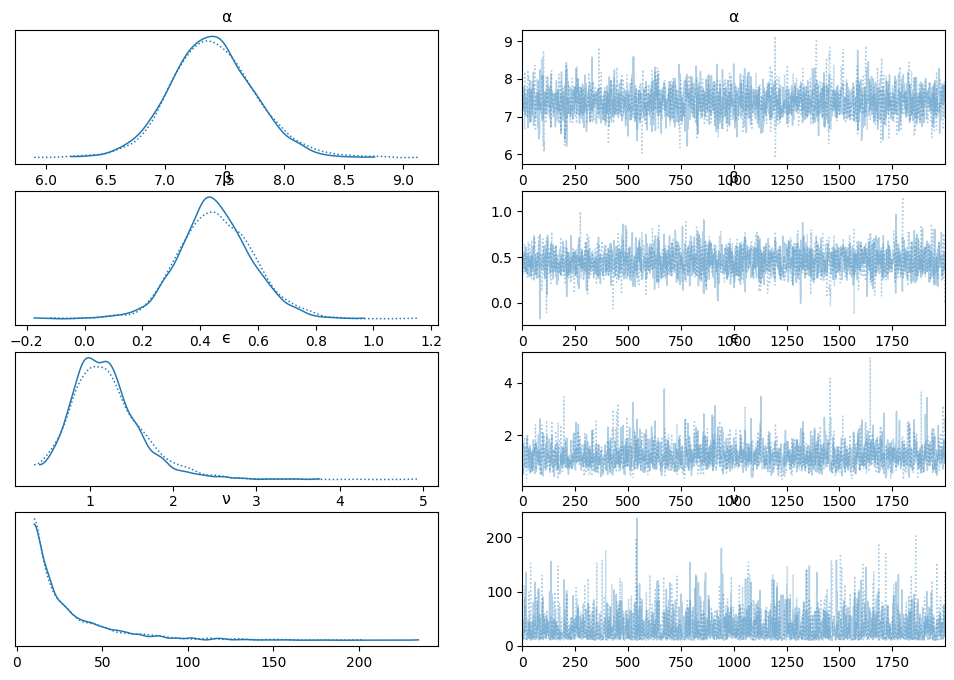

In [34]:
varnames = ['α', 'β', 'ϵ', 'ν']
az.plot_trace(idata_t, var_names=varnames);

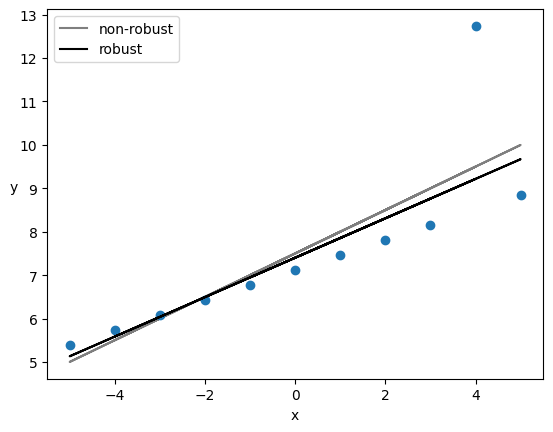

In [35]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

posterior_mean = az.extract(idata_t).mean()

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')
alpha_m = posterior_mean['α'].item()
beta_m = posterior_mean['β'].item()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)

In [36]:
az.summary(idata_t, var_names=varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,7.401,0.366,6.769,8.134,0.008,0.009,1928.0,1553.0,1.0
β,0.454,0.130,0.228,0.712,0.003,0.003,2361.0,2114.0,1.0
ϵ,1.201,0.427,0.450,1.949,0.011,0.010,1301.0,854.0,1.0
ν,31.570,25.324,10.000,77.780,0.485,0.665,1590.0,1248.0,1.0


In [37]:
pm.sample_posterior_predictive(idata_t, model=model_t, random_seed=2, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 12.0)

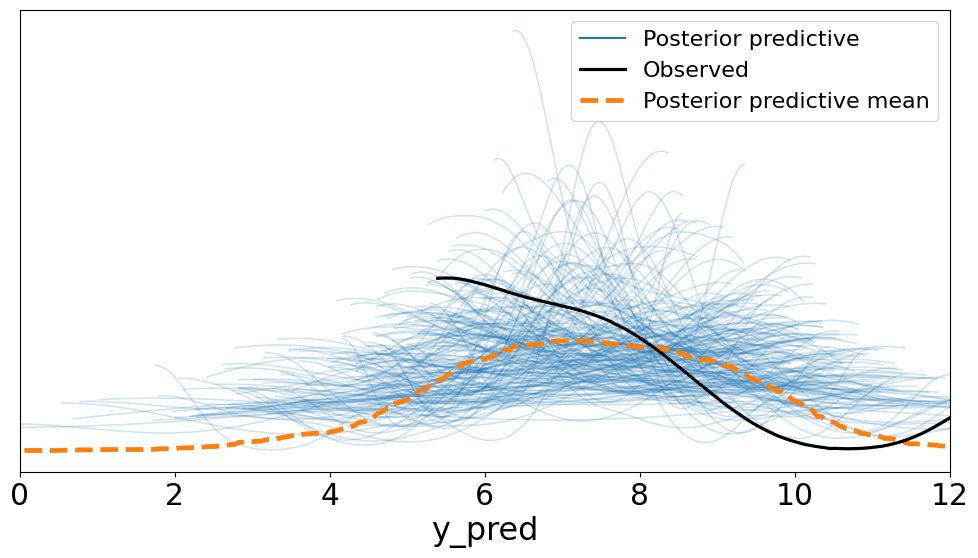

In [38]:
ax = az.plot_ppc(idata_t, num_pp_samples=200, figsize=(12, 6), mean=True)
plt.xlim(0, 12)

## Hierarchical regression

It turns out, we can use Bayesian methods to solve problems that are simply impossible by classical methods. For example, can we fit a line to a single point? Turns out we can do it, if we have other data sets and have reasons to believe that they share some common data generation process.

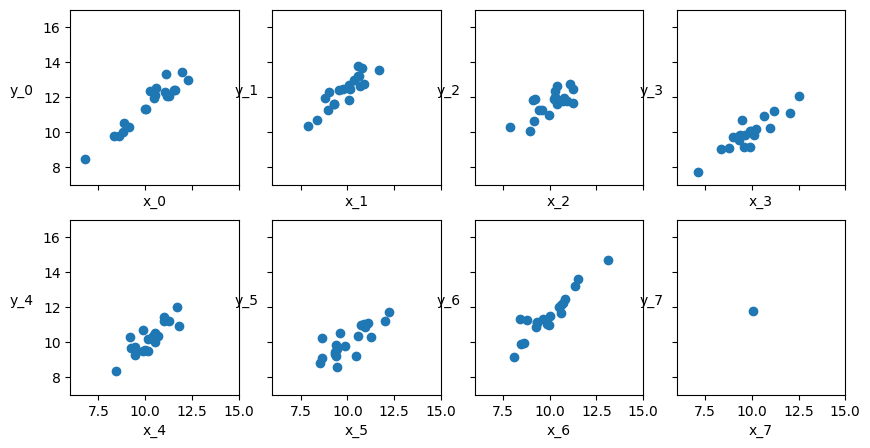

In [39]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N

In [40]:
x_centered = x_m - x_m.mean()

Let's fit this data independently

In [41]:
with pm.Model() as unpooled_model:
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10, shape=M)
    β = pm.Normal('β', mu=0, sigma=10, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sigma=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())

    idata_up = pm.sample(2000, target_accept=0.9)

Output()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

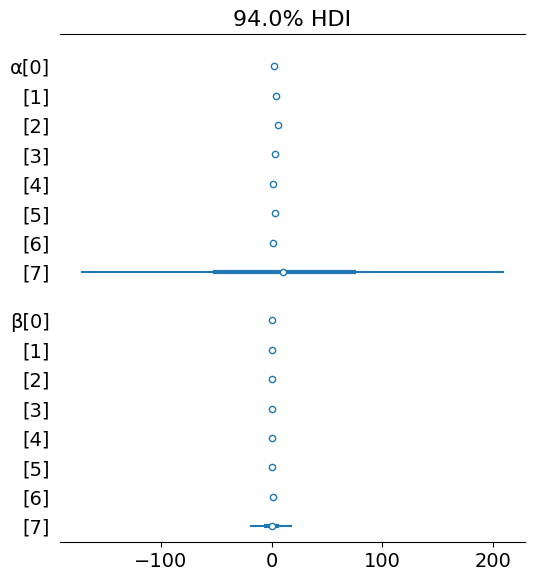

In [42]:
az.plot_forest(idata_up, var_names=['α', 'β'], combined=True)

And now let's make hierarchical model

In [43]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sigma=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 10)
    β_μ = pm.Normal('β_μ', mu=0, sigma=10)
    β_σ = pm.HalfNormal('β_σ', sigma=10)

    # priors
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sigma=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sigma=β_σ, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sigma=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())

    idata_hm = pm.sample(2000, target_accept=0.99)

Output()

ERROR:pymc.stats.convergence:There were 19 divergences after tuning. Increase `target_accept` or reparameterize.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

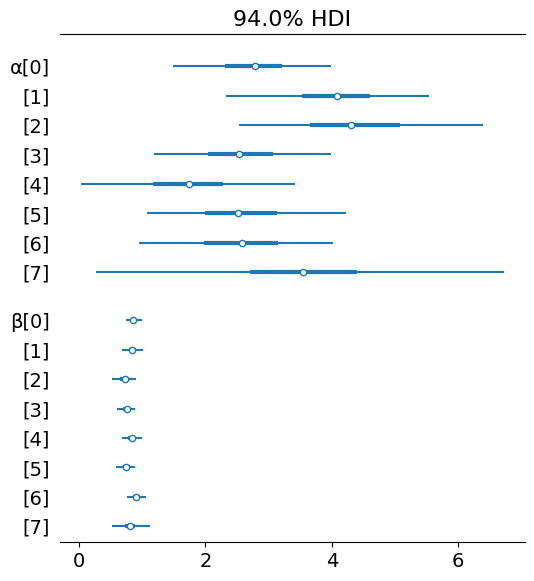

In [44]:
az.plot_forest(idata_hm, var_names=['α', 'β'], combined=True)

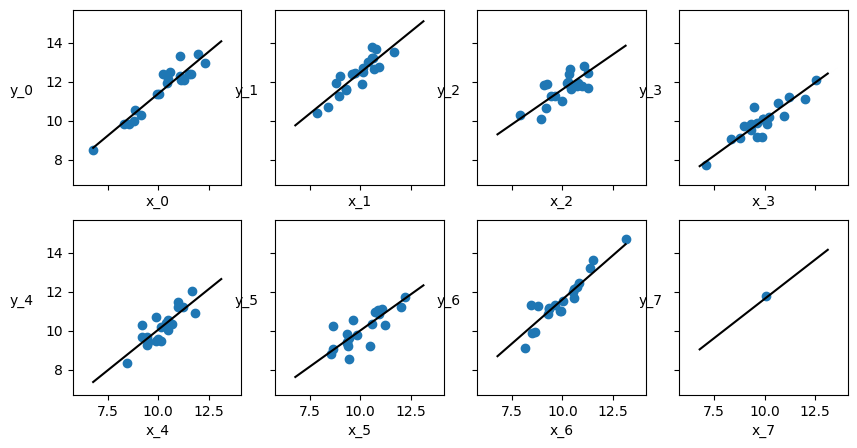

In [45]:
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)

posterior_hm = az.extract(idata_hm)

for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = posterior_hm["α"].sel({"α_dim_0":i}).mean().item()
    beta_m = posterior_hm["β"].sel({"β_dim_0":i}).mean().item()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N